# Blinkit Sales Forecasting

## Problem statement
### Retail and e-commerce businesses face challenges in predicting sales, leading to stock issues and financial inefficiencies. This project aims to         develop  a machine learning model to forecast future sales using historical data, enabling better inventory management and planning.

In [105]:
#Loading the dataset
import pandas as pd

df=pd.read_csv('blinkit_orders_dataset.csv')

In [107]:
df.shape

(5250, 10)

In [109]:
df.head()

,order_id,customer_id,order_date,promised_delivery_time,actual_delivery_time,delivery_status,order_total,payment_method,delivery_partner_id,store_id
0,1961864118,30065862,2024-07-17 08:34:01,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771
1,1549769649,9573071,2024-05-28 13:14:29,2024-05-28 13:25:29,2024-05-28 13:27:29,On Time,976.55,Cash,14983,7534
2,9185164487,45477575,2024-09-23 13:07:12,2024-09-23 13:25:12,2024-09-23 13:29:12,On Time,839.05,UPI,39859,9886
3,9644738826,88067569,2023-11-24 16:16:56,2023-11-24 16:34:56,2023-11-24 16:33:56,On Time,440.23,Card,61497,7917
4,5427684290,83298567,2023-11-20 05:00:39,2023-11-20 05:17:39,2023-11-20 05:18:39,On Time,2526.68,Cash,84315,2741


## Explaining the columns
### order_id    – A unique identifier for each order.
### customer_id – A unique identifier for the customer who placed the order.
### order_date  – The date and time when the order was placed.
### promised_delivery_time – The estimated delivery time given to the customer when they placed the order.
### actual_delivery_time   – The actual time when the order was delivered.
### delivery_status        – The status of the delivery (e.g., "On Time", "Delayed").
### order_total            – The total amount paid for the order.
### payment_method         – The mode of payment used (e.g., Cash, UPI, Card).
### delivery_partner_id    – A unique identifier for the delivery partner assigned to fulfill the order.
### store_id               – A unique identifier for the store from which the order was fulfilled.

In [112]:
#finding the null vlaues
df.isnull().sum()

order_id                    0
customer_id                 0
order_date                  0
promised_delivery_time      0
actual_delivery_time        0
delivery_status           173
order_total               252
payment_method            194
delivery_partner_id         0
store_id                    0
dtype: int64

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                5250 non-null   int64  
 1   customer_id             5250 non-null   int64  
 2   order_date              5250 non-null   object 
 3   promised_delivery_time  5250 non-null   object 
 4   actual_delivery_time    5250 non-null   object 
 5   delivery_status         5077 non-null   object 
 6   order_total             4998 non-null   float64
 7   payment_method          5056 non-null   object 
 8   delivery_partner_id     5250 non-null   int64  
 9   store_id                5250 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 410.3+ KB


### Ploting box plot for checking outliers

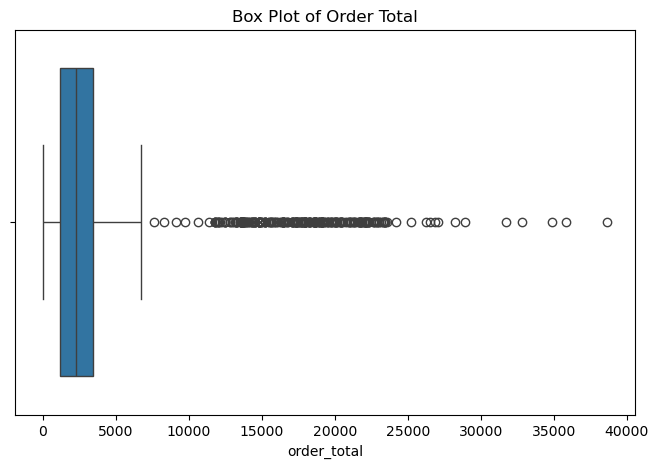

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['order_total'])
plt.title("Box Plot of Order Total")
plt.show()

### Removing outliers using IQR method

In [120]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'order_total')

### Handling missing values

In [123]:
#Imputing the null values with median or mode
df.update(df[['order_total']].fillna(df['order_total'].median()))
df.update(df[['payment_method']].fillna(df['payment_method'].mode()[0]))
df.update(df[['delivery_status']].fillna(df['delivery_status'].mode()[0]))


In [125]:
df.isnull().sum()

order_id                  0
customer_id               0
order_date                0
promised_delivery_time    0
actual_delivery_time      0
delivery_status           0
order_total               0
payment_method            0
delivery_partner_id       0
store_id                  0
dtype: int64

In [127]:
df.shape

(4711, 10)

In [129]:
df1=df.copy()

### Importing the libraries for feature engineering ,encoding and  feature  scaling

In [132]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

### Featuring engineering

In [135]:
# ✅ Convert order_date and delivery times to datetime format
df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")
df["promised_delivery_time"] = pd.to_datetime(df["promised_delivery_time"], errors="coerce")
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"], errors="coerce")

# Extract Date & Time Features
df["order_day"] = df["order_date"].dt.day
df["order_month"] = df["order_date"].dt.month
df["order_year"] = df["order_date"].dt.year
df["order_weekday"] = df["order_date"].dt.weekday  # 0 = Monday, 6 = Sunday
df["order_hour"] = df["order_date"].dt.hour
df["is_weekend"] = df["order_weekday"].apply(lambda x: 1 if x >= 5 else 0)  # 1 for Saturday & Sunday

# Aggregate Sales Data
daily_sales = df.groupby(df["order_date"].dt.date)["order_total"].sum().reset_index()
daily_sales.columns = ["date", "daily_total_sales"]

daily_orders = df.groupby(df["order_date"].dt.date)["order_id"].count().reset_index()
daily_orders.columns = ["date", "daily_order_count"]

# Store-Wise Sales
store_sales = df.groupby("store_id")["order_total"].sum().reset_index()
store_sales.columns = ["store_id", "total_store_sales"]

# Payment Method Insights
payment_sales = df.groupby("payment_method")["order_total"].sum().reset_index()
payment_sales.columns = ["payment_method", "total_payment_sales"]

# Delivery Delay Calculation (Optional)
df["delivery_delay"] = (df["actual_delivery_time"] - df["promised_delivery_time"]).dt.total_seconds() / 60  # Delay in minutes

# Merge Daily Sales & Orders
sales_data = pd.merge(daily_sales, daily_orders, on="date")

# ✅ Display Feature Engineered Data
print("Processed Order Data:\n", df.head(), "\n")
print("Daily Sales & Order Count:\n", sales_data.head(), "\n")
print("Store-Wise Sales:\n", store_sales.head(), "\n")
print("Payment Method Sales:\n", payment_sales.head(), "\n")

# Return Data for Further Use
processed_data = {
    "orders": df,
    "daily_sales": sales_data,
    "store_sales": store_sales,
    "payment_sales": payment_sales,
}



Processed Order Data:
      order_id  customer_id          order_date promised_delivery_time  \
0  1961864118     30065862 2024-07-17 08:34:01    2024-07-17 08:52:01   
1  1549769649      9573071 2024-05-28 13:14:29    2024-05-28 13:25:29   
2  9185164487     45477575 2024-09-23 13:07:12    2024-09-23 13:25:12   
3  9644738826     88067569 2023-11-24 16:16:56    2023-11-24 16:34:56   
4  5427684290     83298567 2023-11-20 05:00:39    2023-11-20 05:17:39   

  actual_delivery_time delivery_status  order_total payment_method  \
0  2024-07-17 08:47:01         On Time      3197.07           Cash   
1  2024-05-28 13:27:29         On Time       976.55           Cash   
2  2024-09-23 13:29:12         On Time       839.05            UPI   
3  2023-11-24 16:33:56         On Time       440.23           Card   
4  2023-11-20 05:18:39         On Time      2526.68           Cash   

   delivery_partner_id  store_id  order_day  order_month  order_year  \
0                63230      4771         17  

📊 Model Performance:
MAE: 3340.20
RMSE: 4100.10
R² Score: 0.72


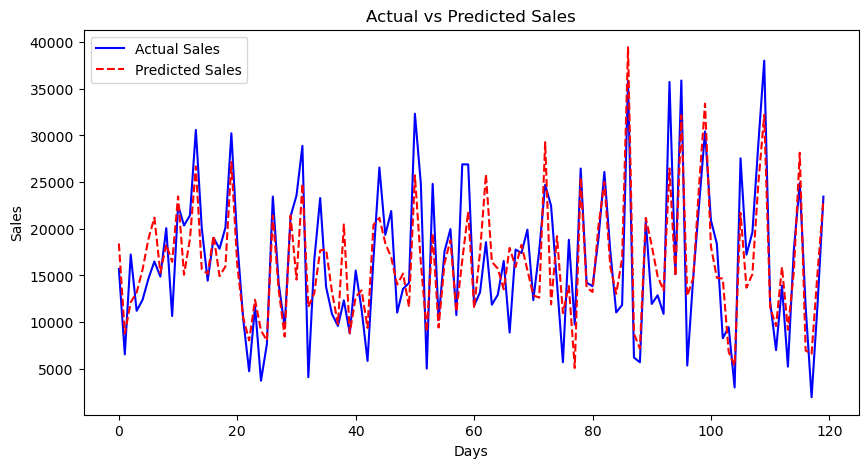

In [137]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Feature Engineered Data
df = processed_data["daily_sales"]  # Using daily aggregated sales

# Convert date column to datetime format
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by="date")  # Ensure data is sorted

# Feature Engineering: Extract time-based features
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["weekday"] = df["date"].dt.weekday  # 0 = Monday, 6 = Sunday
df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# Define Features (X) and Target (y)
X = df[["day", "month", "year", "weekday", "is_weekend", "daily_order_count"]]
y = df["daily_total_sales"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predict on Test Data
y_pred = model.predict(X_test)

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot Actual vs Predicted Sales
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Sales", color="blue")
plt.plot(y_pred, label="Predicted Sales", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Actual vs Predicted Sales")
plt.show()


C:\Users\M.Deemanth Reddy\AppData\Local\Temp\ipykernel_11164\976397440.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sales_df.fillna(method='bfill', inplace=True)


Average Cross-Validated R²: 0.9427026166479314
Train MAE: 11.293218767882221, Train RMSE: 15.368641443654953, Train R²: 0.9998625261319596
Final Test MAE: 178.86819381796923, RMSE: 233.64059195620538, R²: 0.9675883711478253


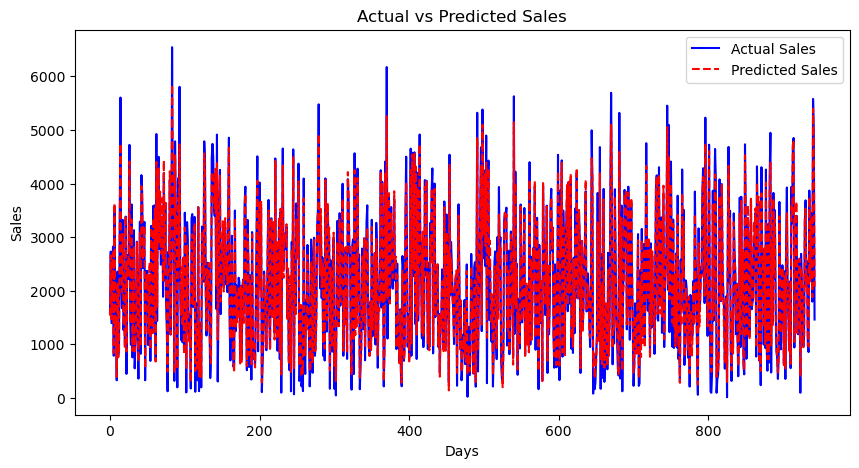

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# Convert to datetime
df1['order_date'] = pd.to_datetime(df1['order_date'])

# Aggregate sales
sales_df = df1.groupby('order_date')['order_total'].sum().reset_index()

# Extract time features
sales_df['month'] = sales_df['order_date'].dt.month
sales_df['weekday'] = sales_df['order_date'].dt.weekday
sales_df['hour'] = sales_df['order_date'].dt.hour
sales_df['weekofyear'] = sales_df['order_date'].dt.isocalendar().week
sales_df['is_weekend'] = (sales_df['weekday'] >= 5).astype(int)

# Create lag and rolling features
sales_df['prev_day_sales'] = sales_df['order_total'].shift(1)
sales_df['last_week_sales'] = sales_df['order_total'].shift(7)
sales_df['rolling_3'] = sales_df['order_total'].rolling(3).mean()
sales_df['rolling_7'] = sales_df['order_total'].rolling(7).mean()
sales_df['rolling_30'] = sales_df['order_total'].rolling(30).mean()

# New lag features
sales_df['lag_2'] = sales_df['order_total'].shift(2)
sales_df['lag_3'] = sales_df['order_total'].shift(3)
sales_df['lag_4'] = sales_df['order_total'].shift(4)
sales_df['lag_14'] = sales_df['order_total'].shift(14)
sales_df['lag_30'] = sales_df['order_total'].shift(30)

# Exponential Moving Averages (EMA)
sales_df['ema_7'] = sales_df['order_total'].ewm(span=7, adjust=False).mean()
sales_df['ema_30'] = sales_df['order_total'].ewm(span=30, adjust=False).mean()

# Add holiday feature
holidays = ['2024-01-01', '2024-08-15', '2024-10-02', '2024-12-25']
sales_df['is_holiday'] = sales_df['order_date'].astype(str).isin(holidays).astype(int)

# Fill missing values
sales_df.fillna(method='bfill', inplace=True)

# Define features and target
X = sales_df[['prev_day_sales', 'last_week_sales', 'rolling_3', 'rolling_7', 'rolling_30', 
              'month', 'weekday', 'hour', 'weekofyear', 'is_weekend', 'lag_2', 'lag_3', 
              'lag_4', 'lag_14', 'lag_30', 'ema_7', 'ema_30', 'is_holiday']]
y = sales_df['order_total']

# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=7)

# Train XGBoost model with regularization
model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.03, 
    max_depth=8, 
    min_child_weight=10,  # Prevents overfitting
    subsample=0.8,  # Randomly samples 80% data
    colsample_bytree=0.8,  # Uses 80% features per tree
    gamma=0.2,  # Adds regularization
    reg_alpha=0.1,  # L1 Regularization
    reg_lambda=1,  # L2 Regularization
    objective='reg:squarederror'
)

# Cross-validation scores
cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
print(f"Average Cross-Validated R²: {np.mean(cv_scores)}")

# Train the final model
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Evaluation
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print(f"Train MAE: {train_mae}, Train RMSE: {train_rmse}, Train R²: {train_r2}")
print(f"Final Test MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}")

# Plot Actual vs Predicted Sales
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Sales", color="blue")
plt.plot(y_pred, label="Predicted Sales", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sales")
plt.title("Actual vs Predicted Sales")
plt.show()
